# STEP 0: Setup Kaggle API and Download Dataset

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()  # Upload your kaggle.json here

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d yamqwe/leaf-types-object-detection
!unzip -q leaf-types-object-detection.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/yamqwe/leaf-types-object-detection
License(s): CC0-1.0
  0% 0.00/45.6M [00:00<?, ?B/s]
100% 45.6M/45.6M [00:00<00:00, 1.16GB/s]


# STEP 1: Parse XML Annotations (PASCAL VOC)

In [ ]:
import os
import xml.etree.ElementTree as ET

def extract_boxes_labels(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    boxes = []
    labels = []

    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)

    return boxes, labels


# STEP 2: Image + Bounding Box Loader

In [ ]:
import cv2
import numpy as np

IMG_SIZE = 128

def load_data(image_dir, annot_dir, limit=None):
    X, y, boxes = [], [], []

    filenames = sorted(os.listdir(image_dir))[:limit]

    for file in filenames:
        image_path = os.path.join(image_dir, file)
        xml_path = os.path.join(annot_dir, file.replace(".png", ".xml"))

        img = cv2.imread(image_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        try:
            bboxes, labels = extract_boxes_labels(xml_path)
            if len(bboxes) > 0:
                X.append(img)
                # Take first bounding box only
                box = bboxes[0]
                # Normalize box coords to [0, 1] range
                box = [
                    box[0] / img.shape[1],
                    box[1] / img.shape[0],
                    box[2] / img.shape[1],
                    box[3] / img.shape[0]
                ]
                boxes.append(box)
        except:
            continue

    return np.array(X), np.array(boxes)


# STEP 3: Load the Dataset

In [ ]:
X, y_boxes = load_data("images", "annotations", limit=1000)
print("Images:", X.shape, "Bounding Boxes:", y_boxes.shape)


Images: (997, 128, 128, 3) Bounding Boxes: (997, 4)


# STEP 4: Sample Image from dataset

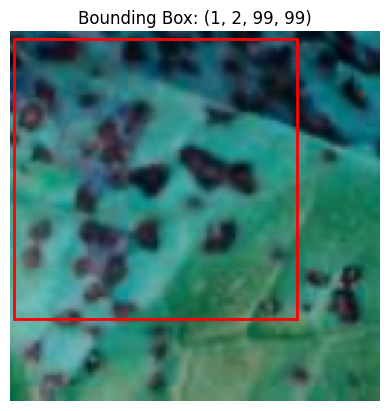

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_sample(index):
    image = X[index]
    box = y_boxes[index]

    h, w = IMG_SIZE, IMG_SIZE
    xmin = int(box[0] * w)
    ymin = int(box[1] * h)
    xmax = int(box[2] * w)
    ymax = int(box[3] * h)

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    rect = patches.Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(rect)
    plt.title(f"Bounding Box: {xmin, ymin, xmax, ymax}")
    plt.axis('off')
    plt.show()

# Show any index (e.g., 0 to 10)
show_sample(0)


# STEP 4: Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_boxes, test_size=0.2, random_state=42
)


# STEP 5: CNN Model Architecture (From Scratch)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_custom_cnn():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(4, activation='sigmoid')  # Output: xmin, ymin, xmax, ymax (normalized)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_custom_cnn()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# STEP 6: Train the Model

In [ ]:
history = model.fit(X_train, y_train, epochs=15,
                    validation_data=(X_test, y_test),
                    batch_size=32)


Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 0.0445 - mae: 0.1700 - val_loss: 0.0313 - val_mae: 0.1427
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 0.0285 - mae: 0.1404 - val_loss: 0.0279 - val_mae: 0.1396
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 0.0267 - mae: 0.1359 - val_loss: 0.0261 - val_mae: 0.1334
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0264 - mae: 0.1335 - val_loss: 0.0261 - val_mae: 0.1352
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0235 - mae: 0.1260 - val_loss: 0.0246 - val_mae: 0.1300
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0207 - mae: 0.1177 - val_loss: 0.0251 - val_mae: 0.1325
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.0200 - mae: 0.1158 - val_loss: 0.0242 - val_mae: 0.1253
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.0173 - mae: 0.1056 - val_loss: 0.0256 - val_mae: 0.1309
Epoch 9/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 0.0155 - mae: 

# STEP 7: Evaluate Model Performance

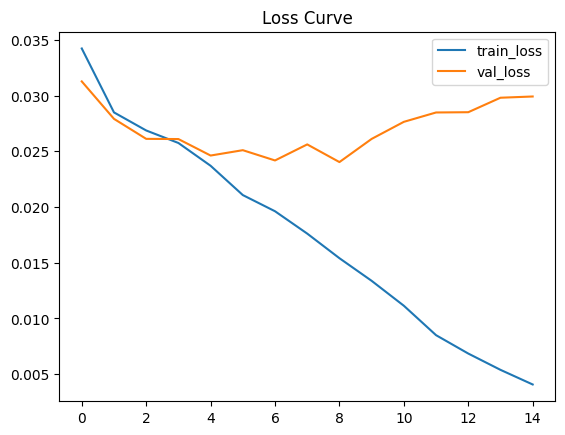

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Loss Curve")
plt.show()


# STEP 8: Visualize Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


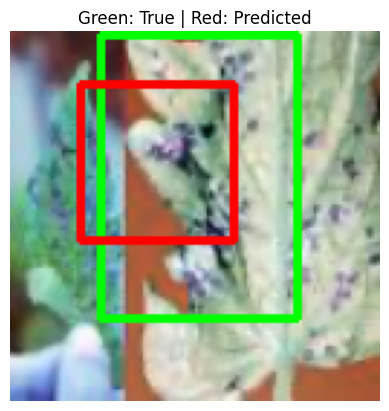

In [10]:
def show_prediction(index):
    image = X_test[index]
    true_box = y_test[index]
    pred_box = model.predict(np.expand_dims(image, axis=0))[0]

    h, w = IMG_SIZE, IMG_SIZE

    image_draw = (image * 255).astype("uint8").copy()

    # True box in green
    cv2.rectangle(image_draw,
                  (int(true_box[0]*w), int(true_box[1]*h)),
                  (int(true_box[2]*w), int(true_box[3]*h)),
                  (0,255,0), 2)

    # Predicted box in red
    cv2.rectangle(image_draw,
                  (int(pred_box[0]*w), int(pred_box[1]*h)),
                  (int(pred_box[2]*w), int(pred_box[3]*h)),
                  (255,0,0), 2)

    plt.imshow(image_draw)
    plt.axis('off')
    plt.title('Green: True | Red: Predicted')
    plt.show()

show_prediction(0)


# STEP 9: Save Model

In [11]:
model.save("leaf_cnn_detector.h5")

# Step B: CNN Variation 1 – Extra Conv Layer

In [12]:
def build_cnn_variation_1():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(256, (3,3), activation='relu'),  # Extra layer
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(4, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Step C: CNN Variation 2 – Dropout Added

In [13]:
def build_cnn_variation_2():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dropout(0.3),  # Regularization
        layers.Dense(128, activation='relu'),
        layers.Dense(4, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Step D: Train All Models

In [14]:
# Base model already trained as: model
model1 = model

# Train variation 1
model2 = build_cnn_variation_1()
history2 = model2.fit(X_train, y_train, epochs=15,
                      validation_data=(X_test, y_test), batch_size=32)

# Train variation 2
model3 = build_cnn_variation_2()
history3 = model3.fit(X_train, y_train, epochs=15,
                      validation_data=(X_test, y_test), batch_size=32)


Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 0.0428 - mae: 0.1670 - val_loss: 0.0284 - val_mae: 0.1415
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 0.0286 - mae: 0.1420 - val_loss: 0.0278 - val_mae: 0.1395
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - loss: 0.0282 - mae: 0.1413 - val_loss: 0.0290 - val_mae: 0.1364
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0274 - mae: 0.1370 - val_loss: 0.0258 - val_mae: 0.1372
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.0261 - mae: 0.1340 - val_loss: 0.0257 - val_mae: 0.1292
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0234 - mae: 0.1249 - val_loss: 0.0239 - val_mae: 0.1262
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0222 - mae: 0.1219 - val_loss: 0.0235 - val_mae: 0.1239
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0218 - mae: 0.1205 - val_loss: 0.0234 - val_mae: 0.1232
Epoch 9/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0210 - mae: 

# Step E: Compare Loss Curves

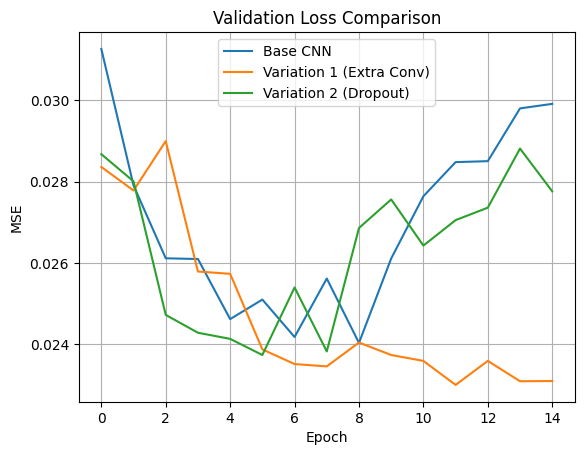

In [15]:
# Reuse existing history from your model as history1
history1 = history  # From base model

def plot_all_losses(h1, h2, h3):
    plt.plot(h1.history['val_loss'], label='Base CNN')
    plt.plot(h2.history['val_loss'], label='Variation 1 (Extra Conv)')
    plt.plot(h3.history['val_loss'], label='Variation 2 (Dropout)')
    plt.title("Validation Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_all_losses(history1, history2, history3)


# Step F: Save All 3 Models

In [16]:
model1.save("leaf_base_cnn.h5")
model2.save("leaf_cnn_extra_conv.h5")
model3.save("leaf_cnn_dropout.h5")


# Step G: Compare Predictions Visually

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


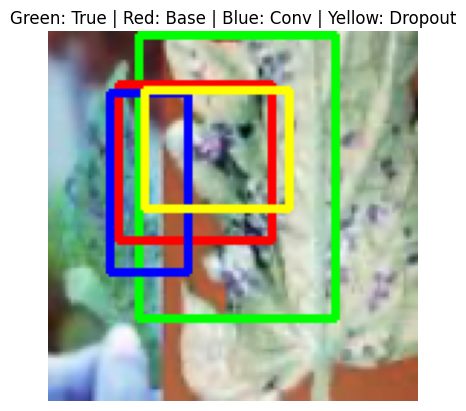

In [17]:
def compare_model_predictions(index):
    h, w = IMG_SIZE, IMG_SIZE
    image = X_test[index]
    true_box = y_test[index]

    pred1 = model1.predict(np.expand_dims(image, axis=0))[0]
    pred2 = model2.predict(np.expand_dims(image, axis=0))[0]
    pred3 = model3.predict(np.expand_dims(image, axis=0))[0]

    image_draw = (image * 255).astype("uint8").copy()

    # Ground Truth (Green)
    cv2.rectangle(image_draw,
                  (int(true_box[0]*w), int(true_box[1]*h)),
                  (int(true_box[2]*w), int(true_box[3]*h)),
                  (0,255,0), 2)

    # Model 1 (Red)
    cv2.rectangle(image_draw,
                  (int(pred1[0]*w), int(pred1[1]*h)),
                  (int(pred1[2]*w), int(pred1[3]*h)),
                  (255,0,0), 2)

    # Model 2 (Blue)
    cv2.rectangle(image_draw,
                  (int(pred2[0]*w), int(pred2[1]*h)),
                  (int(pred2[2]*w), int(pred2[3]*h)),
                  (0,0,255), 2)

    # Model 3 (Yellow)
    cv2.rectangle(image_draw,
                  (int(pred3[0]*w), int(pred3[1]*h)),
                  (int(pred3[2]*w), int(pred3[3]*h)),
                  (255,255,0), 2)

    plt.imshow(image_draw)
    plt.axis('off')
    plt.title("Green: True | Red: Base | Blue: Conv | Yellow: Dropout")
    plt.show()

compare_model_predictions(0)
